In [2]:
import pandas as pd
import numpy as np
import re
import glob
from sklearn.preprocessing import MinMaxScaler

def extract_labels_from_filename(filename):
    # Extract frequency in kHz
    frequency_match = re.search(r'W_f(\d+)kHz_', filename)
    frequency = int(frequency_match.group(1)) if frequency_match else None

    # Extract notch depth in mm (integer or decimal)
    depth_match = re.search(r'ed_([\d.]+)mm_not', filename)
    notch_depth = float(depth_match.group(1)) if depth_match else 0 

    # Extract notch width in mm (integer or decimal)
    width_match = re.search(r'th_([\d.]+)mm_notchwidth', filename)
    notch_width = float(width_match.group(1)) if width_match else 0 

    return frequency, notch_depth, notch_width


def load_and_preprocess(directory):
    data = []
    labels = []

    # Use glob to find all Excel files in the specified directory
    files = glob.glob(f'{directory}/*.xlsx')
    
    for file in files:
        df = pd.read_excel(file)
        signal = df['voltage_noisy'].values

        # Take only the first 10,000 points of the signal
        signal = signal[:20000]

        # Extract frequency, notch depth, and notch width from filename
        frequency, notch_depth, notch_width = extract_labels_from_filename(file)

        data.append(signal)
        labels.append([frequency, notch_depth, notch_width])

    return np.array(data), np.array(labels)

# Specify the directory where your files are located
directory = 'E:\Simulation'  # Update this path as needed

# Load and preprocess data
data, labels = load_and_preprocess(directory)

# Normalize the data
# Flatten and normalize signals using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_flattened = data.reshape(data.shape[0], -1)  # Flatten signals for scaling
data_normalized = scaler.fit_transform(data_flattened)  # Normalize data
data_normalized = data_normalized.reshape(data.shape)  # Reshape back to original

# Normalize the labels
labels_scaler = MinMaxScaler()
labels_normalized = labels_scaler.fit_transform(labels)

# Outputs: `data_normalized` and `labels_normalized` are normalized datasets
print("Data normalized shape:", data_normalized.shape)
print("Labels normalized shape:", labels_normalized.shape)


Data normalized shape: (255, 20000)
Labels normalized shape: (255, 3)


In [3]:
data=data_normalized
labels=labels_normalized

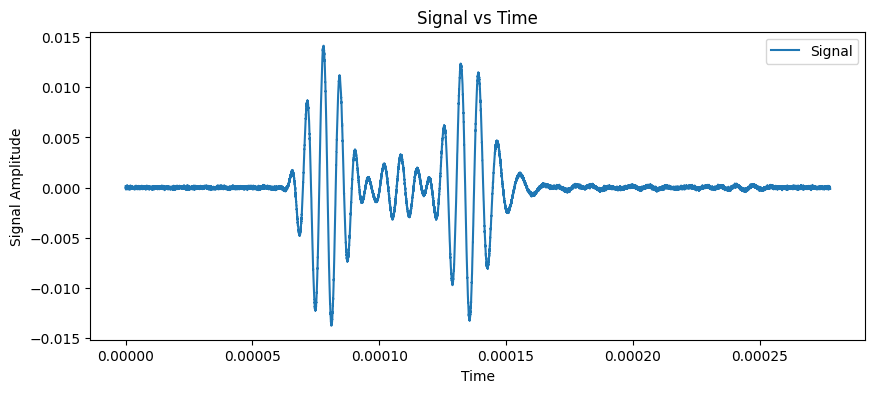

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

file_pa = 'E:\Simulation\Exp_FW_f150kHz_5tb_20V_cos_damaged_4mm_notchdepth_4mm_notchwidth_30dB.xlsx'
df = pd.read_excel(file_pa)[:20000]

# Look for columns with 'time' (case insensitive) in the name
time_column = [col for col in df.columns if 'time' in col.lower()][:20000]

# Ensure we have found a time column
if time_column:
    time = df[time_column[0]].values
else:
    raise ValueError("No time column found in the data.")

plt.figure(figsize=(10, 4))
plt.plot(time, df.iloc[:, 1], label='Signal')  # Assuming the signal data is in the second column
plt.xlabel('Time')
plt.ylabel('Signal Amplitude')
plt.title('Signal vs Time')
plt.legend()
plt.show()


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Build Convolutional Autoencoder (CAE)
def build_cae(input_shape):
    # Encoder
    input_signal = layers.Input(shape=input_shape)
    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(input_signal)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    latent = layers.Dense(7, activation='linear', name='latent')(x)  # Latent space with 7 dimensions

    # Decoder
    x = layers.Dense(64, activation='relu')(latent)
    x = layers.Dense(input_shape[0] // 4 * 32, activation='relu')(x)
    x = layers.Reshape((input_shape[0] // 4, 32))(x)
    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(1, kernel_size=3, activation='linear', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)

    cae = models.Model(inputs=input_signal, outputs=x)
    return cae

# Build the CAE
input_shape = (data.shape[1], 1)  # `data` should be your input dataset
cae = build_cae(input_shape)
cae.compile(optimizer='adam', loss='mse')


In [17]:
data = data.reshape(-1, data.shape[1], 1)  # Reshape input to fit CAE
cae.fit(data, data, epochs=50, batch_size=16, validation_split=0.1)



Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 520ms/step - loss: 0.1314 - val_loss: 0.0330
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 469ms/step - loss: 0.0357 - val_loss: 0.0234
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 481ms/step - loss: 0.0305 - val_loss: 0.0215
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 502ms/step - loss: 0.0289 - val_loss: 0.0208
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 490ms/step - loss: 0.0256 - val_loss: 0.0207
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 453ms/step - loss: 0.0226 - val_loss: 0.0179
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 447ms/step - loss: 0.0177 - val_loss: 0.0185
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 448ms/step - loss: 0.0166 - val_loss: 0.0170
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 446ms/step - loss: 0.0153 - val_loss: 0.0168
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 451ms/step - loss: 0.0156 - val_loss: 0.0165
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 447ms/step - loss: 0.0144 - val_loss: 0.0160
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 448ms/step

In [18]:
from tensorflow.keras import layers, models

# Encoder
encoder = models.Model(inputs=cae.input, outputs=cae.get_layer(name='latent').output)

# Rebuild Decoder
decoder_input = layers.Input(shape=(7,))  # Latent space dimension
x = decoder_input
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(input_shape[0] // 4 * 64, activation='relu')(x)  # Adjusted for compatibility
x = layers.Reshape((input_shape[0] // 4, 64))(x)  # Reshaping to maintain element count
x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(size=2)(x)
x = layers.Conv1D(1, kernel_size=3, activation='linear', padding='same')(x)
x = layers.UpSampling1D(size=2)(x)
decoder = models.Model(inputs=decoder_input, outputs=x)

# Build FFNN for State Estimation (FFNN1)
def build_ffn1(latent_dim):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(latent_dim,)),  # latent_dim matches encoder's output
        layers.Dense(3, activation='linear')  # Output: frequency, notch depth, notch width
    ])
    return model

# Build FFNN for Latent Space Reconstruction (FFNN2)
def build_ffn2(latent_dim):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(3,)),  # Input: 3 states (frequency, notch depth, notch width)
        layers.Dense(latent_dim, activation='linear')  # Output: latent representation
    ])
    return model

# Build and Compile FFNNs
latent_dim = 7
ffn1 = build_ffn1(latent_dim=latent_dim)
ffn2 = build_ffn2(latent_dim=latent_dim)

# Compile the models
ffn1.compile(optimizer='adam', loss='mse')  # For state estimation
ffn2.compile(optimizer='adam', loss='mse')  # For latent space reconstruction


c:\Users\91993\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
encoded_data = encoder.predict(data)  # Pass input data through the encoder

# Print the encoded data shape for verification
print(f"Encoded data shape: {encoded_data.shape}")  # Should be (num_samples, 7)

# Prepare Labels for FFNN1 Training
# `labels` should contain the target states: frequency, notch depth, notch width
# Ensure labels shape matches (num_samples, 3)

# Train FFNN1
ffn1.compile(optimizer='adam', loss='mse')
ffn1.fit(encoded_data, labels, epochs=50, batch_size=16, validation_split=0.1)



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
Encoded data shape: (255, 7)
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0413 - val_loss: 1.2713
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6337 - val_loss: 0.9209
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5878 - val_loss: 0.2441
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3752 - val_loss: 0.2210
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2746 - val_loss: 0.2446
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1925 - val_loss: 0.1993
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1633 - val_loss: 0.1952
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1174 - val_loss: 0.1715
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0968 - val_loss: 0.1671
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1016 - val_loss: 0.1198
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0838 - val_loss: 0.1333
Epoch 

In [20]:
# Train FFNN2 (Optional if latent reconstruction is needed)
ffn2.compile(optimizer='adam', loss='mse')
ffn2.fit(labels, encoded_data, epochs=50, batch_size=16, validation_split=0.1)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 107.1931 - val_loss: 112.9822
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106.8428 - val_loss: 110.4785
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104.2069 - val_loss: 107.5526
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101.9190 - val_loss: 103.9537
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99.4346 - val_loss: 99.4970
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 96.3624 - val_loss: 94.0741
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 91.4631 - val_loss: 87.4582
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87.4242 - val_loss: 80.0378
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 82.3247 - val_loss: 72.2271
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 76.3222 - val_loss: 63.9543
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70.0635 - val_loss: 55.6795
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

In [33]:
print("CAE Model Summary:")
cae.summary()

print("\nState Predictor Model Summary:")
ffn1.summary()

print("\nState-to-Latent Model Summary:")
ffn2.summary()

CAE Model Summary:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 20000, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 20000, 128)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 10000, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 10000, 64)      │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 5000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 320000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │    20,480,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 7)              │           455 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 160000)         │    10,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 5000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 5000, 128)      │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_4 (UpSampling1D)  │ (None, 10000, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 10000, 1)       │           385 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_5 (UpSampling1D)  │ (None, 20000, 1)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,756,954 (353.84 MB)

 Trainable params: 30,918,984 (117.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,837,970 (235.89 MB)


State Predictor Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,123 (8.30 KB)

 Trainable params: 707 (2.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,416 (5.54 KB)


State-to-Latent Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,135 (8.34 KB)

 Trainable params: 711 (2.78 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,424 (5.57 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Frequency (kHz): 101.46115
Predicted Notch Depth (mm): 0.7317859
Predicted Notch Width (mm): 0.9086605
RMSE for Notch Depth and Notch Width: 2.1941192866158343
RMSE Error: 0.003093733057777608


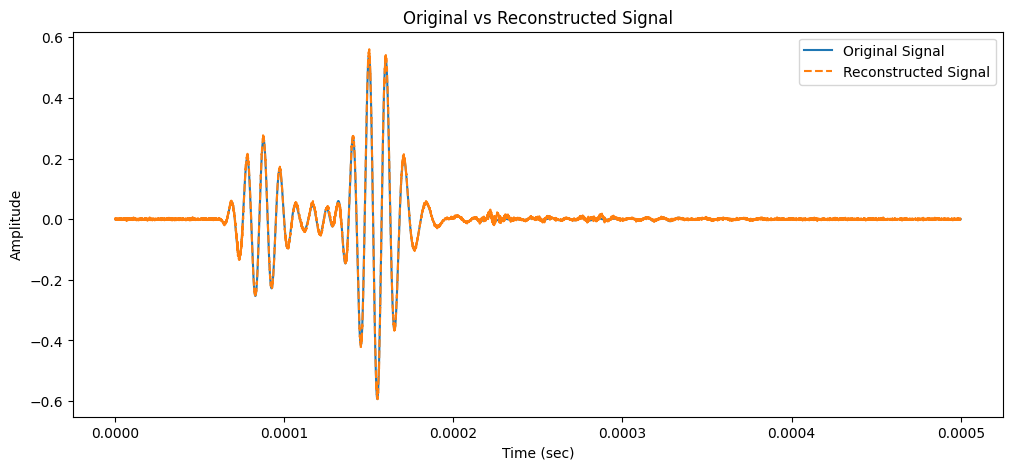

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def load_test_signal(file_path):
    # Load test signal and downsample
    df = pd.read_excel(file_path)
    test_signal = df['voltage_noisy'].values
    time = df['time(sec)'].values
    return test_signal.reshape(1, -1, 1), time  # Reshape for model input

test_file_path = 'E:\Simulation\Exp_FW_f150kHz_5tb_20V_cos_damaged_1mm_notchdepth_4mm_notchwidth.xlsx'

# Load test signal and time
test_data, time = load_test_signal(test_file_path)

# Normalize the test data using the same scaler used during training
test_data_normalized = scaler.transform(test_data.reshape(1, -1)).reshape(1, -1, 1)

# 1. Predict latent representation using the encoder
encoded_test_data = encoder.predict(test_data_normalized)

# 2. Predict structural state using FFN1
predicted_state_normalized = ffn1.predict(encoded_test_data)

# Transform predicted state back to original scale
predicted_state_original = labels_scaler.inverse_transform(predicted_state_normalized)
freq, predicted_notch_depth, predicted_notch_width = predicted_state_original[0]

# 3. Reconstruct the signal using the CAE
reconstructed_signal_normalized = cae.predict(test_data_normalized)

# Denormalize the reconstructed signal for comparison
reconstructed_signal = scaler.inverse_transform(reconstructed_signal_normalized.reshape(1, -1)).flatten()

# 4. Calculate RMSE between original and reconstructed signals
rmse_error = np.sqrt(mean_squared_error(test_data.flatten(), reconstructed_signal))

# Output results
print("Predicted Frequency (kHz):", freq)
print("Predicted Notch Depth (mm):", predicted_notch_depth)
print("Predicted Notch Width (mm):", predicted_notch_width)
true_values = np.array([1.0, 4.0])  # True values: [notch depth, notch width]
predicted_values = np.array([predicted_notch_depth, predicted_notch_width])

# Calculate combined RMSE
rmse_combined = np.sqrt(mean_squared_error(true_values, predicted_values))

# Output the combined RMSE
print("RMSE for Notch Depth and Notch Width:", rmse_combined)
print("RMSE Error:", rmse_error)

# Plot original and reconstructed signals for comparison
plt.figure(figsize=(12, 5))
plt.plot(time[:10000], test_data.flatten()[:10000], label='Original Signal')
plt.plot(time[:10000], reconstructed_signal[:10000], label='Reconstructed Signal', linestyle='--')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Signal')
plt.legend()
plt.show()
# Assume these are the true values for notch depth and width



In [110]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define the Convolutional Autoencoder (CAE)
def build_cae(input_shape, latent_dim):
    # Encoder
    input_signal = Input(shape=input_shape, name="input_signal")
    x = Conv1D(64, 3, activation='relu', padding='same')(input_signal)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Flatten()(x)
    latent_space = Dense(latent_dim, activation='relu', name="latent_space")(x)
    
    # Decoder
    x = Dense((input_shape[0] // 4) * 32, activation='relu')(latent_space)
    x = Reshape((input_shape[0] // 4, 32))(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    reconstructed_signal = Conv1D(1, 3, activation='sigmoid', padding='same', name="reconstructed_signal")(x)

    return Model(input_signal, reconstructed_signal, name="CAE")

# Define the Feedforward Neural Networks (FFNNs)
def build_ffnn(input_dim, output_dim):
    model = tf.keras.Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(output_dim, activation='linear')
    ])
    return model

# Parameters
latent_dim = 7  # Latent space dimension

# Simulated Data Dimensions
# Assuming data_normalized and labels_normalized are prepared using your preprocessing code
sequence_length = 2000  # Example length after downsampling
num_signals = 195  # Example number of signals
num_labels = 3  # Example number of labels (frequency, notch depth, notch width)

# Generate random data for demonstration
data_normalized = np.random.rand(num_signals, sequence_length)
labels_normalized = np.random.rand(num_signals, num_labels)

# Reshape data to include the channel dimension
data_normalized = data_normalized.reshape(data_normalized.shape[0], data_normalized.shape[1], 1)

# Update input shape
input_shape = data_normalized.shape[1:]  # (sequence_length, 1)
state_dim = labels_normalized.shape[1]  # Number of state variables (e.g., 3)

# Build Models
cae = build_cae(input_shape, latent_dim)

# Encoder Model
encoder = Model(cae.input, cae.get_layer("latent_space").output, name="Encoder")

# Decoder Model
decoder_input = Input(shape=(latent_dim,), name="decoder_input")
x = Dense((input_shape[0] // 4) * 32, activation='relu')(decoder_input)
x = Reshape((input_shape[0] // 4, 32))(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
decoder_output = Conv1D(1, 3, activation='sigmoid', padding='same', name="reconstructed_signal")(x)
decoder = Model(decoder_input, decoder_output, name="Decoder")

# FFNNs for state estimation and signal reconstruction
ffnn_state_estimation = build_ffnn(latent_dim, state_dim)
ffnn_signal_generation = build_ffnn(state_dim, latent_dim)

# Compile Models
cae.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
ffnn_state_estimation.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
ffnn_signal_generation.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Training
# Train CAE
history_cae = cae.fit(
    data_normalized, data_normalized,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

# Train FFNN for state estimation
latent_representations = encoder.predict(data_normalized)
history_state_estimation = ffnn_state_estimation.fit(
    latent_representations, labels_normalized,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

# Train FFNN for signal reconstruction
history_signal_generation = ffnn_signal_generation.fit(
    labels_normalized, latent_representations,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

# Outputs
print("CAE, State Estimation FFNN, and Signal Reconstruction FFNN training complete.")


Epoch 1/10


c:\Users\91993\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0835 - mae: 0.2503 - val_loss: 0.0834 - val_mae: 0.2501
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0833 - mae: 0.2499 - val_loss: 0.0834 - val_mae: 0.2501
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0834 - mae: 0.2502 - val_loss: 0.0835 - val_mae: 0.2502
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0834 - mae: 0.2501 - val_loss: 0.0836 - val_mae: 0.2503
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0831 - mae: 0.2497 - val_loss: 0.0836 - val_mae: 0.2503
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0831 - mae: 0.2495 - val_loss: 0.0836 - val_mae: 0.2503
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0831 - mae: 0.2495 - val_loss: 0.0837 - val_mae: 0.2504
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0831 - mae: 0.2496 - val_loss: 0.0836 - val_mae: 0.2503
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0831 - mae: 0.2497 - val_loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Frequency (kHz): 134.33159
Predicted Notch Depth (mm): 0.62326
Predicted Notch Width (mm): 3.6134136
RMSE Error: 0.051578924225218446


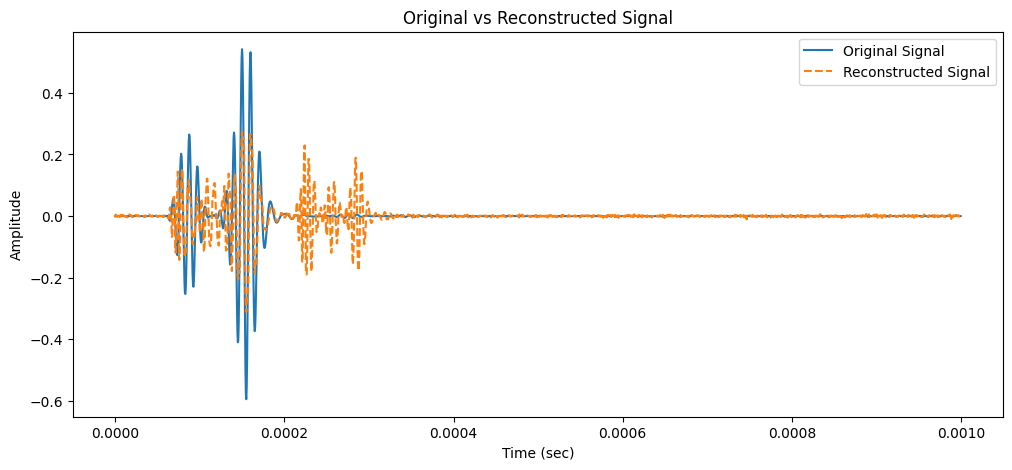

In [112]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def load_test_signal(file_path, downsample_factor=10):
    # Load test signal and downsample
    df = pd.read_excel(file_path)
    test_signal = df['voltage_noisy'].values[::downsample_factor]
    time = df['time(sec)'].values[::downsample_factor]
    return test_signal.reshape(1, -1, 1), time  # Reshape for model input

test_file_path = 'E:\Simulation\Sim_FW_f100kHz_5tb_20V_cos_damaged_0mm_notchdepth_0mm_notchwidth.xlsx'

# Load test signal and time
test_data, time = load_test_signal(test_file_path)

# Normalize the test data using the same scaler used during training
test_data_normalized = scaler.transform(test_data.reshape(1, -1)).reshape(1, -1, 1)

# 1. Predict latent representation using the encoder
encoded_test_data = encoder.predict(test_data_normalized)

# 2. Predict structural state using FFNN for state estimation
predicted_state_normalized = ffnn_state_estimation.predict(encoded_test_data)

# Transform predicted state back to the original scale using the labels scaler
predicted_state_original = labels_scaler.inverse_transform(predicted_state_normalized)
freq, predicted_notch_depth, predicted_notch_width = predicted_state_original[0]

# 3. Reconstruct the signal using the CAE
reconstructed_signal_normalized = cae.predict(test_data_normalized)

# Denormalize the reconstructed signal for comparison
reconstructed_signal = scaler.inverse_transform(reconstructed_signal_normalized.reshape(1, -1)).flatten()

# 4. Calculate RMSE between original and reconstructed signals
rmse_error = np.sqrt(mean_squared_error(test_data.flatten(), reconstructed_signal))

# Output results
print("Predicted Frequency (kHz):", freq)
print("Predicted Notch Depth (mm):", predicted_notch_depth)
print("Predicted Notch Width (mm):", predicted_notch_width)
print("RMSE Error:", rmse_error)

# Plot original and reconstructed signals for comparison
plt.figure(figsize=(12, 5))
plt.plot(time, test_data.flatten(), label='Original Signal')
plt.plot(time, reconstructed_signal, label='Reconstructed Signal', linestyle='--')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Signal')
plt.legend()
plt.show()
